In [4]:
# Cell 1
def import_dependencies():
    import torch
    import torch.nn as nn
    import torch.optim as optim
    import torchvision
    import torchvision.transforms as transforms
    from torch.utils.data import DataLoader, Subset
    import numpy as np
    import random
    import matplotlib.pyplot as plt
    return torch, nn, optim, torchvision, transforms, DataLoader, Subset, np, random, plt

torch, nn, optim, torchvision, transforms, DataLoader, Subset, np, random, plt = import_dependencies()


In [5]:
# Cell 2
def load_cifar10(batch_size=64):
    transform = transforms.Compose([
        transforms.ToTensor(),
    ])

    trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
    testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

    trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
    testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

    return trainloader, testloader

trainloader, testloader = load_cifar10()


In [6]:
# Cell 3
class MCAE(nn.Module):
    def __init__(self, masking_ratio=0.5):
        super(MCAE, self).__init__()
        self.masking_ratio = masking_ratio

        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1), nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1), nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1), nn.ReLU()
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1), nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1), nn.ReLU(),
            nn.Conv2d(64, 3, kernel_size=3, stride=1, padding=1), nn.Sigmoid()
        )

    def mask_features(self, features):
        B, C, H, W = features.size()
        num_patches = H * W
        num_mask = int(self.masking_ratio * num_patches)

        mask = torch.ones((B, H * W), device=features.device)
        for i in range(B):
            rand_indices = torch.randperm(H * W)[:num_mask]
            mask[i, rand_indices] = 0
        mask = mask.view(B, 1, H, W)
        return features * mask

    def forward(self, x):
        encoded = self.encoder(x)
        masked = self.mask_features(encoded)
        decoded = self.decoder(masked)
        return decoded, encoded


In [7]:
# Cell 4
def train_mcae(model, dataloader, device, epochs=10, lr=1e-3):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    model.to(device)

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for images, _ in dataloader:
            images = images.to(device)
            optimizer.zero_grad()
            outputs, _ = model(images)
            loss = criterion(outputs, images)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(dataloader):.4f}")

    return model


In [8]:
# Cell 5
class LinearClassifier(nn.Module):
    def __init__(self, feature_dim, num_classes=10):
        super().__init__()
        self.fc = nn.Linear(feature_dim, num_classes)

    def forward(self, x):
        return self.fc(x)

def evaluate_with_linear_classifier(model, trainloader, testloader, device):
    model.eval()
    features_train, labels_train = [], []
    features_test, labels_test = [], []

    with torch.no_grad():
        for images, labels in trainloader:
            images = images.to(device)
            _, encoded = model(images)
            features_train.append(encoded.view(encoded.size(0), -1).cpu())
            labels_train.append(labels)

        for images, labels in testloader:
            images = images.to(device)
            _, encoded = model(images)
            features_test.append(encoded.view(encoded.size(0), -1).cpu())
            labels_test.append(labels)

    X_train = torch.cat(features_train)
    y_train = torch.cat(labels_train)
    X_test = torch.cat(features_test)
    y_test = torch.cat(labels_test)

    clf = LinearClassifier(feature_dim=X_train.shape[1])
    clf.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(clf.parameters(), lr=1e-3)

    for epoch in range(10):
        clf.train()
        optimizer.zero_grad()
        outputs = clf(X_train.to(device))
        loss = criterion(outputs, y_train.to(device))
        loss.backward()
        optimizer.step()

    clf.eval()
    with torch.no_grad():
        preds = clf(X_test.to(device)).argmax(dim=1)
        acc = (preds.cpu() == y_test).float().mean()
        print(f"Linear classification accuracy: {acc.item() * 100:.2f}%")
        return acc


In [6]:
#cell 6
def evaluate_reconstruction_quality(model, dataloader, device):
    model.eval()
    total_mse, total_psnr = 0.0, 0.0
    criterion = nn.MSELoss()

    with torch.no_grad():
        for images, _ in dataloader:
            images = images.to(device)
            outputs, _ = model(images)
            mse = criterion(outputs, images).item()
            psnr = 10 * torch.log10(torch.tensor(1.0) / torch.tensor(mse))  # Fixed line
            total_mse += mse
            total_psnr += psnr.item()

    avg_mse = total_mse / len(dataloader)
    avg_psnr = total_psnr / len(dataloader)
    print(f"Reconstruction - Avg MSE: {avg_mse:.4f}, Avg PSNR: {avg_psnr:.2f} dB")
    return avg_mse, avg_psnr


In [8]:
def main(masking_ratio=0.5):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    trainloader, testloader = load_cifar10()
    model = MCAE(masking_ratio=masking_ratio)

    print("Training MCAE with masking ratio:", masking_ratio)
    model = train_mcae(model, trainloader, device, epochs=10)

    print("\nEvaluating reconstruction quality...")
    mse, psnr = evaluate_reconstruction_quality(model, testloader, device)

    print("\nEvaluating linear classifier on frozen embeddings...")
    acc = evaluate_with_linear_classifier(model, trainloader, testloader, device)

    print("\n Summary:")
    print(f"Masking Ratio       : {masking_ratio}")
    print(f"Reconstruction MSE  : {mse:.4f}")
    print(f"Reconstruction PSNR : {psnr:.2f} dB")
    print(f"Linear Accuracy     : {acc * 100:.2f}%")

    return mse, psnr, acc


In [8]:
# Run and collect results
mse, psnr, acc = main(masking_ratio=0.5)


Training MCAE with masking ratio: 0.5
Epoch [1/10], Loss: 0.0091
Epoch [2/10], Loss: 0.0035
Epoch [3/10], Loss: 0.0028
Epoch [4/10], Loss: 0.0025
Epoch [5/10], Loss: 0.0024
Epoch [6/10], Loss: 0.0022
Epoch [7/10], Loss: 0.0021
Epoch [8/10], Loss: 0.0021
Epoch [9/10], Loss: 0.0020
Epoch [10/10], Loss: 0.0020

Evaluating reconstruction quality...
Reconstruction - Avg MSE: 0.0020, Avg PSNR: 26.96 dB

Evaluating linear classifier on frozen embeddings...
Linear classification accuracy: 24.13%

📊 Summary:
Masking Ratio       : 0.5
Reconstruction MSE  : 0.0020
Reconstruction PSNR : 26.96 dB
Linear Accuracy     : 24.13%


In [1]:
# # Cell 8
# def main(masking_ratio=0.5):
#     device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#     trainloader, testloader = load_cifar10()
#     model = MCAE(masking_ratio=masking_ratio)
#     print("Training MCAE with masking ratio:", masking_ratio)
#     model = train_mcae(model, trainloader, device, epochs=10)

#     print("\nEvaluating reconstruction quality...")
#     evaluate_reconstruction_quality(model, testloader, device)
#     print("Evaluating linear classifier on frozen embeddings...")
#     evaluate_with_linear_classifier(model, trainloader, testloader, device)

# # Example run:
# main(masking_ratio=0.5)


In [7]:

# Cell 7
def compare_feature_extraction(masking_ratios=[]):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    trainloader, testloader = load_cifar10()
    results = {}

    for ratio in masking_ratios:
        print(f"\n==== Masking Ratio: {ratio} ====")
        model = MCAE(masking_ratio=ratio)
        model = train_mcae(model, trainloader, device, epochs=10)  # Keep fewer epochs for speed
        acc = evaluate_with_linear_classifier_return(model, trainloader, testloader, device)
        results[ratio] = acc
        print(f"Accuracy @ Masking {ratio}: {acc:.2f}%")

    return results


In [8]:
# Cell 8
def evaluate_with_linear_classifier_return(model, trainloader, testloader, device):
    model.eval()
    features_train, labels_train = [], []
    features_test, labels_test = [], []

    with torch.no_grad():
        for images, labels in trainloader:
            images = images.to(device)
            _, encoded = model(images)
            features_train.append(encoded.view(encoded.size(0), -1).cpu())
            labels_train.append(labels)

        for images, labels in testloader:
            images = images.to(device)
            _, encoded = model(images)
            features_test.append(encoded.view(encoded.size(0), -1).cpu())
            labels_test.append(labels)

    X_train = torch.cat(features_train)
    y_train = torch.cat(labels_train)
    X_test = torch.cat(features_test)
    y_test = torch.cat(labels_test)

    clf = LinearClassifier(feature_dim=X_train.shape[1])
    clf.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(clf.parameters(), lr=1e-3)

    for epoch in range(10):
        clf.train()
        optimizer.zero_grad()
        outputs = clf(X_train.to(device))
        loss = criterion(outputs, y_train.to(device))
        loss.backward()
        optimizer.step()

    clf.eval()
    with torch.no_grad():
        preds = clf(X_test.to(device)).argmax(dim=1)
        acc = (preds.cpu() == y_test).float().mean().item() * 100
    return acc


In [9]:
# Cell 9
def plot_comparison(results):
    ratios = list(results.keys())
    accuracies = list(results.values())

    plt.figure(figsize=(8, 5))
    plt.plot(ratios, accuracies, marker='o')
    plt.xlabel("Masking Ratio")
    plt.ylabel("Classification Accuracy (%)")
    plt.title("Feature Quality vs. Masking Ratio")
    plt.grid(True)
    plt.show()




In [ ]:
# Example run
results = compare_feature_extraction([0.0,0.9])
plot_comparison(results)


==== Masking Ratio: 0.0 ====
Epoch [1/10], Loss: 0.0044
Epoch [2/10], Loss: 0.0007
Epoch [3/10], Loss: 0.0004
Epoch [4/10], Loss: 0.0003
Epoch [5/10], Loss: 0.0003
Epoch [6/10], Loss: 0.0002
Epoch [7/10], Loss: 0.0002
Epoch [8/10], Loss: 0.0002
Epoch [9/10], Loss: 0.0002
Epoch [10/10], Loss: 0.0002
Accuracy @ Masking 0.0: 25.23%

==== Masking Ratio: 0.9 ====
Epoch [1/10], Loss: 0.0350
Epoch [2/10], Loss: 0.0313
Epoch [3/10], Loss: 0.0306
Epoch [4/10], Loss: 0.0302
Epoch [5/10], Loss: 0.0301
Epoch [6/10], Loss: 0.0300
Epoch [7/10], Loss: 0.0299
Epoch [8/10], Loss: 0.0298
Epoch [9/10], Loss: 0.0297
Epoch [10/10], Loss: 0.0297


In [13]:
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from matplotlib.colors import ListedColormap

def plot_decision_regions_mcae(model, dataloader, device):
    model.eval()
    features, labels = [], []

    with torch.no_grad():
        for images, lbls in dataloader:
            images = images.to(device)
            _, encoded = model(images)
            encoded = encoded.view(encoded.size(0), -1).cpu().numpy()
            features.append(encoded)
            labels.append(lbls.numpy())

    X = np.concatenate(features)
    y = np.concatenate(labels)

    # Standardize and reduce to 2D
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_scaled)

    # Train linear classifier on 2D PCA features
    clf = LogisticRegression(max_iter=200)
    clf.fit(X_pca, y)

    # Create decision region grid
    h = .05  # mesh step size
    x_min, x_max = X_pca[:, 0].min() - 1, X_pca[:, 0].max() + 1
    y_min, y_max = X_pca[:, 1].min() - 1, X_pca[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    # Plot
    plt.figure(figsize=(10, 6))
    cmap = ListedColormap(plt.cm.tab10.colors[:10])
    plt.contourf(xx, yy, Z, alpha=0.3, cmap=cmap)
    scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap=cmap, edgecolors='k', s=20)
    plt.legend(*scatter.legend_elements(), title="Classes")
    plt.title("Decision Regions on MCAE Embeddings (PCA 2D)")
    plt.xlabel("PCA 1")
    plt.ylabel("PCA 2")
    plt.grid(True)
    plt.show()


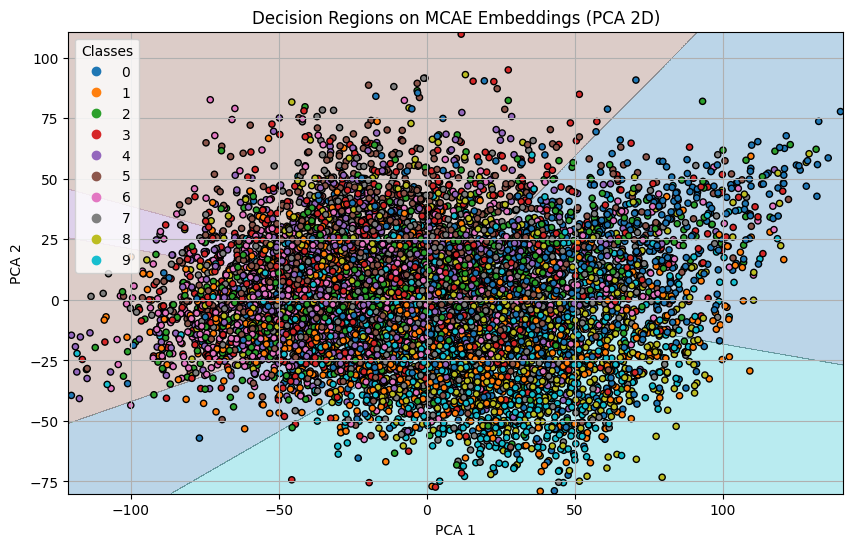

In [15]:
model.to(device)
plot_decision_regions_mcae(model, testloader, device)



In [24]:
from sklearn.model_selection import train_test_split

def plot_confusion_heatmap(model, dataloader, device):
    model.eval()
    features, labels = [], []

    with torch.no_grad():
        for images, lbls in dataloader:
            images = images.to(device)
            _, encoded = model(images)
            encoded = encoded.view(encoded.size(0), -1).cpu().numpy()
            features.append(encoded)
            labels.append(lbls.numpy())

    X = np.concatenate(features)
    y = np.concatenate(labels)

    # 🔀 Split into train/test sets for classifier
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    # Scale features
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Train classifier
    clf = LogisticRegression(max_iter=200)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    # 📊 Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap="coolwarm", xticklabels=range(10), yticklabels=range(10))
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Heatmap of mcae)")
    plt.show()


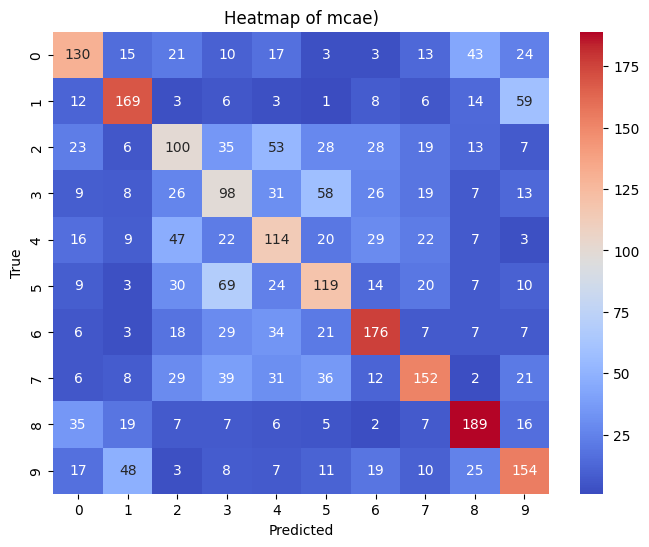

In [25]:
# model.to(device)  # just in case it's not already on CUDA
# # plot_decision_regions_mcae(model, testloader, device)
# plot_confusion_heatmap(model, testloader, device)
plot_confusion_heatmap(model, testloader, device)


In [ ]:
# Cell 10
def extract_embeddings(model, dataloader, device):
    model.eval()
    features, labels = [], []

    with torch.no_grad():
        for images, lbls in dataloader:
            images = images.to(device)
            _, encoded = model(images)
            feat = encoded.view(encoded.size(0), -1).cpu().numpy()
            features.append(feat)
            labels.append(lbls.numpy())

    return np.vstack(features), np.hstack(labels)


In [ ]:
# Cell 11
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

def reduce_embeddings(X, method='tsne'):
    if method == 'tsne':
        reducer = TSNE(n_components=2, random_state=42, perplexity=30)
    elif method == 'pca':
        reducer = PCA(n_components=2)
    else:
        raise ValueError("Choose 'tsne' or 'pca'")

    X_2d = reducer.fit_transform(X)
    return X_2d


In [ ]:
# Cell 12
from sklearn.linear_model import LogisticRegression
from matplotlib.colors import ListedColormap

def plot_decision_regions(X_2d, y, title="Decision Regions"):
    clf = LogisticRegression(multi_class='ovr', max_iter=1000)
    clf.fit(X_2d, y)

    x_min, x_max = X_2d[:, 0].min() - 1, X_2d[:, 0].max() + 1
    y_min, y_max = X_2d[:, 1].min() - 1, X_2d[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300),
                         np.linspace(y_min, y_max, 300))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF',
                                 '#FFFFAA', '#FFAADD', '#55FFCC',
                                 '#CCAAFF', '#AADDFF', '#FFCCAA', '#CCFFAA'])

    plt.figure(figsize=(8, 6))
    plt.contourf(xx, yy, Z, alpha=0.3, cmap=cmap_light)
    scatter = plt.scatter(X_2d[:, 0], X_2d[:, 1], c=y, cmap='tab10', edgecolor='k', s=30)
    plt.title(title)
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    plt.legend(*scatter.legend_elements(), title="Classes", loc="best")
    plt.grid(True)
    plt.show()


In [ ]:
# Cell 13 (Updated)
def visualize_decision_regions(model, dataloader, device, reducer='pca', max_samples=2000):
    print("Extracting embeddings...")
    X, y = extract_embeddings(model, dataloader, device)

    # Use only a subset for speed
    if len(X) > max_samples:
        idx = np.random.choice(len(X), max_samples, replace=False)
        X = X[idx]
        y = y[idx]

    print(f"Reducing dimensions using {reducer.upper()}...")
    X_2d = reduce_embeddings(X, method=reducer)
    print("Plotting decision regions...")
    plot_decision_regions(X_2d, y, title=f"Decision Regions (Reducer: {reducer})")



In [ ]:
# Reuse trained model from before
# Let's say this was your previous main run
# model = MCAE(masking_ratio=0.5)
# model = train_mcae(model, trainloader, device, epochs=20)

# Now pass it here (no re-training)
visualize_decision_regions(model=model, dataloader=trainloader, device=device, reducer='pca')


NameError: name 'model' is not defined

In [ ]:
# Cell 6 (Final Updated main function)
def main(masking_ratio=0.5, compare=False, visualize=False, reducer='pca'):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    trainloader, testloader = load_cifar10()

    if compare:
        print("📊 Comparing multiple masking ratios...")
        results = compare_feature_extraction()
        plot_comparison(results)
        return  # No need to train a single model if comparing all

    # Train MCAE with specific masking ratio
    print("🚀 Training MCAE with masking ratio:", masking_ratio)
    model = MCAE(masking_ratio=masking_ratio)
    model = train_mcae(model, trainloader, device, epochs=10)

    # Evaluate with frozen embeddings
    print("📈 Evaluating linear classifier on frozen features...")
    acc = evaluate_with_linear_classifier_return(model, trainloader, testloader, device)
    print(f"✅ Accuracy: {acc:.2f}%")


# Train with a specific masking ratio and show decision plot
main(masking_ratio=0.5, visualize=True, reducer='pca')

# Compare feature extraction for multiple masking ratios
main(compare=True)



🚀 Training MCAE with masking ratio: 0.5
Epoch [1/10], Loss: 0.0148
Epoch [2/10], Loss: 0.0053
Epoch [3/10], Loss: 0.0040
Epoch [4/10], Loss: 0.0035
Epoch [5/10], Loss: 0.0031
Epoch [6/10], Loss: 0.0029
Epoch [7/10], Loss: 0.0027
Epoch [8/10], Loss: 0.0026
Epoch [9/10], Loss: 0.0025
Epoch [10/10], Loss: 0.0024
📈 Evaluating linear classifier on frozen features...
✅ Accuracy: 14.90%
📊 Comparing multiple masking ratios...

==== Masking Ratio: 0.0 ====
Epoch [1/10], Loss: 0.0088
Epoch [2/10], Loss: 0.0016
Epoch [3/10], Loss: 0.0010
Epoch [4/10], Loss: 0.0007
Epoch [5/10], Loss: 0.0006
Epoch [6/10], Loss: 0.0005
Epoch [7/10], Loss: 0.0004
Epoch [8/10], Loss: 0.0004
Epoch [9/10], Loss: 0.0003
Epoch [10/10], Loss: 0.0003
